# Visualize the distribution of the Self-Recorded training data

Understand the distribution of steering angle for the self-recorded training data

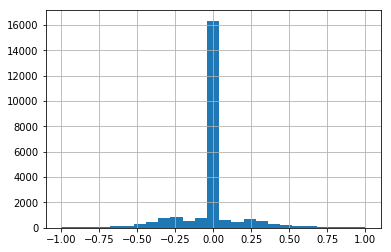

In [1]:
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

train_dir = "./train/"
train_csv_file = train_dir + "driving_log.csv"

train_dataset = pd.read_csv(train_csv_file, usecols=['center', 'left', 'right', 'steering'])
train_dataset.steering.hist(bins=25)

# Visualize the distribution of Udacity provided testing data

Understand the distribution of the steering angle for the udacity provided data

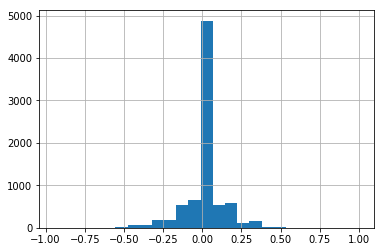

In [2]:
test_dir = "./test/"
test_img_dir = test_dir + "img/"
test_csv_file = test_dir + "driving_log.csv"

test_dataset = pd.read_csv(test_csv_file, usecols=['center', 'left', 'right', 'steering'])
test_dataset.steering.hist(bins=25)

# Visualize the Image Processing steps/parameters prior to training

From the above distribution a significant majority of the samples are recordeded with a steering angle of zero. To balance this we will shift the images horizontally (randomly to the left or right) to simulate the effect of car being at diffrent positions on the track. Additionally, the simulator records images from the left/center/right cameras. Since we can use only one randomly picked image - we adjust steering angle for the left image by +0.25 and the right image by -0.25, to compensate for the camera offsets

The track used for training has a lot left turns. We balance this to some extent by creating recordings while driving the in the opposite direction. Additionally we also flip the images about the vertical axis and invert the sign of steering angle for the flipped images

To account for various enviornmental conditions such as shadows, darker/lighter roads, day/night we generate images with diffrent brightness by converting image to HSV channel and randomly scaling the V channel by a random number between 0.25 - 1.25

Finally we crop the image to remove the horizon and the car's hood and then resize the cropped image to be 200 x 66 to match the size for the NVIDIA and COMMA.AI networks

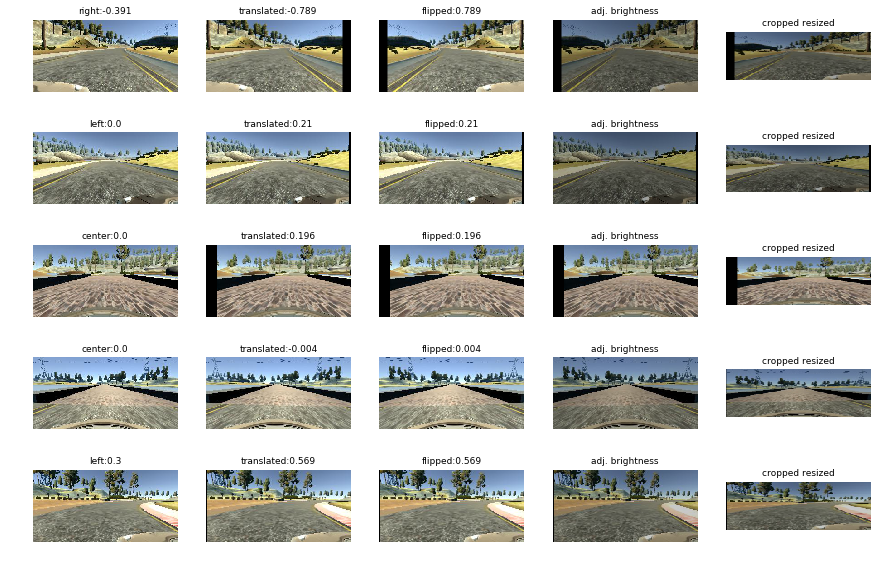

In [15]:
def translate_image(image, steering_angle):
    #get the image dimensions
    rows, cols, channels = image.shape

    #shift image randomly to the left or right for upto 10 px
    shift_range = 50
    tr_x = shift_range*np.random.uniform()-shift_range/2
    
    #no shifts in vertical directions
    tr_y = 0

    translationM = np.float32([[1,0,tr_x],[0,1,tr_y]])
    new_image = cv2.warpAffine(image,translationM,(cols,rows))

    #compute the new steering angle applying a correction factor or 0.2 per pixel
    new_steering_angle = steering_angle + tr_x/shift_range*.4    
    return new_image,new_steering_angle

def flip_image(image, steering_angle):
    if (random.choice([True, False])):
        new_image = cv2.flip(image, 1)
        new_steering_angle = -steering_angle
    else:
        new_image = image
        new_steering_angle = steering_angle
        
    return new_image,new_steering_angle

def augment_brightness(image):
    new_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    new_image[:,:,2] = new_image[:,:,2]*random_bright
    new_image = cv2.cvtColor(new_image,cv2.COLOR_HSV2RGB)

    return new_image

def crop_resize_image(image):
    rows, cols, channels = image.shape

    new_image = image[math.floor(rows/4):(rows-25), 0:cols]
    new_image = cv2.resize(image,(200, 66))    

    return new_image

plt_figure, plt_axis = plt.subplots(5, 5, figsize=(15, 10))
plt_figure.subplots_adjust(hspace = 0.2)
plt_axis = plt_axis.flatten()

i = 0
for sample_index, sample_row in train_dataset.sample(n = 5).iterrows():
    steering_angle = sample_row['steering']
    camera_offset = 0.0
    sel_cam_view = np.random.choice(['center', 'left', 'right'])
    if sel_cam_view == 'left':
        image = cv2.imread(train_dir + sample_row['left'])
        camera_offset += 0.25
    elif sel_cam_view == 'right':
        image = cv2.imread(train_dir + sample_row['right'])
        camera_offset -= 0.25
    else:
        image = cv2.imread(train_dir + sample_row['center'])

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    translated_image, translated_steering_angle = translate_image(image, steering_angle+camera_offset)
    flipped_image, flipped_steering_angle = flip_image(translated_image, translated_steering_angle)
    brightness_adjusted_image = augment_brightness(flipped_image)
    cropped_resized_image = crop_resize_image(brightness_adjusted_image)
    
    plt_axis[i].imshow(image)
    plt_axis[i].set_title(sel_cam_view + ':' + str(np.round(steering_angle, 3)), fontsize=9)
    plt_axis[i].axis('off')    

    plt_axis[i+1].imshow(translated_image)
    plt_axis[i+1].set_title('translated' ':' + str(np.round(translated_steering_angle, 3)), fontsize=9)
    plt_axis[i+1].axis('off')
    
    plt_axis[i+2].imshow(flipped_image)
    plt_axis[i+2].set_title('flipped' ':' + str(np.round(flipped_steering_angle, 3)), fontsize=9)
    plt_axis[i+2].axis('off')

    plt_axis[i+3].imshow(brightness_adjusted_image)
    plt_axis[i+3].set_title('adj. brightness', fontsize=9)
    plt_axis[i+3].axis('off')

    plt_axis[i+4].imshow(cropped_resized_image)
    plt_axis[i+4].set_title('cropped resized', fontsize=9)
    plt_axis[i+4].axis('off')

    i+=5

The below plot show the distribution of the training data post image processing on sample of 10,000 randomly selected images 

(array([  9.00000000e+00,   1.20000000e+01,   2.40000000e+01,
          2.30000000e+01,   4.80000000e+01,   8.40000000e+01,
          1.39000000e+02,   1.93000000e+02,   8.47000000e+02,
          8.88000000e+02,   1.40600000e+03,   1.30400000e+03,
          1.31000000e+03,   1.45300000e+03,   9.12000000e+02,
          8.04000000e+02,   1.91000000e+02,   1.42000000e+02,
          1.07000000e+02,   5.20000000e+01,   2.50000000e+01,
          1.40000000e+01,   9.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([ -1.33401370e+00,  -1.22273461e+00,  -1.11145551e+00,
         -1.00017641e+00,  -8.88897317e-01,  -7.77618220e-01,
         -6.66339123e-01,  -5.55060027e-01,  -4.43780930e-01,
         -3.32501833e-01,  -2.21222737e-01,  -1.09943640e-01,
          1.33545645e-03,   1.12614553e-01,   2.23893650e-01,
          3.35172746e-01,   4.46451843e-01,   5.57730940e-01,
          6.69010036e-01,   7.80289133e-01,   8.91568230e-01,
          1.00284733e+00,   1.11412642e+00

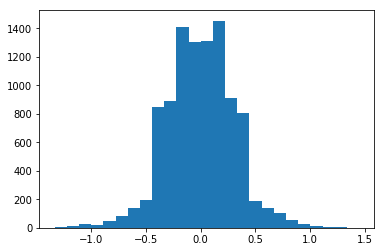

In [16]:
def process_image(image_file, steering_angle):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    translated_image, translated_steering_angle = translate_image(image, steering_angle)
    flipped_image, flipped_steering_angle = flip_image(translated_image, translated_steering_angle)
    brightness_adjusted_image = augment_brightness(flipped_image)
    cropped_resized_image = crop_resize_image(brightness_adjusted_image)

    return cropped_resized_image, flipped_steering_angle

processed_steering_angles = []
for sample_index, sample_row in train_dataset.sample(n = 10000).iterrows():
    steering_angle = sample_row['steering']
    camera_offset = 0.0
    sel_cam_view = np.random.choice(['center', 'left', 'right'])
    if sel_cam_view == 'left':
        image_file = train_dir + sample_row['left']
        camera_offset = 0.25
    elif sel_cam_view == 'right':
        image_file = train_dir + sample_row['right']
        camera_offset = -0.25
    else:
        image_file = train_dir + sample_row['center']

    processed_image, processed_steering_angle = process_image(image_file, steering_angle+camera_offset)
    processed_steering_angles.append(processed_steering_angle)

plt.hist(processed_steering_angles, bins=25)